## <span style="font-family: 'Times New Roman', serif; font-size: 50px; color: white;">Court Case Category Classifier</span>

This notebook builds and evaluates a text classification model to automatically categorize legal case statements into their respective classes (i.e Civil, Criminal, Constitutional). <br>
We built and tested different models during experimentation phase.After evaluation, we selected the best performing model i.e  `voting classifier` built by ensembling ` SVC() `   , `BernoulliNB()`   and   `ExtraTreesClassifier()`.

#### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">Notebook Workflow:</span>

1. Imports used in notebook
2. Reading Data
3. Data Preprocessing
4. Model Building
5. Evaluation
6. Improvements
7. Web app building
    

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">1. Imports Used In Notebook:</span>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score,precision_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

Matplotlib is building the font cache; this may take a moment.


### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">2. Reading Data:</span>

The data is read from a csv file, named  `case_reports_category.csv` located in the same directory as this notebook. It contains `2771` case statements along with their respective categories. The dataset has a shape of `(2771, 2)`, where `first` column represents the case `statement` and `second` represents its `category`

In [2]:
dataset=pd.read_csv('case_reports_category.csv')

In [3]:
dataset.shape

(2771, 2)

In [5]:
dataset.sample(8)

,statement,category
1713,Supreme Court addresses Balochistan's missing ...,Constitutional
2251,SC grants bail to petitioner in triple murder ...,Criminal
1736,"Court addresses Christian Colony violence, pol...",Constitutional
1075,Supreme Court upholds mandatory advertisement ...,Constitutional
2268,SC grants post-arrest bail in a dishonoured ch...,Criminal
997,Postman's pay withholding after reinstatement ...,Civil
1409,Judgment text missing; analysis could not be p...,Civil
495,Specific performance of an unsigned agreement ...,Civil


### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">3. Data Preprocessing:</span>

 Steps: 

 1. Data Cleaning
 2. EDA
 3. Text Preprocessing (vectorization, stemming, removing stop words)

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(a) Data Cleaning:</span>

In [160]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  2738 non-null   object
 1   category   2770 non-null   object
dtypes: object(2)
memory usage: 43.4+ KB


In [161]:
dataset.isnull().sum()

statement    33
category      1
dtype: int64

In [6]:
dataset.dropna(inplace=True)

In [7]:
dataset.duplicated().sum()

np.int64(42)

In [8]:
dataset = dataset.drop_duplicates(keep='first')

In [9]:
dataset.shape

(2696, 2)

In [10]:
dataset.isnull().sum()

statement    0
category     0
dtype: int64

In [11]:
dataset.duplicated().sum()

np.int64(0)

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(b) Exploratory Data Analysis:</span>

In [168]:
dataset['category'].value_counts()

category
Civil             1055
Constitutional     831
Criminal           810
Name: count, dtype: int64

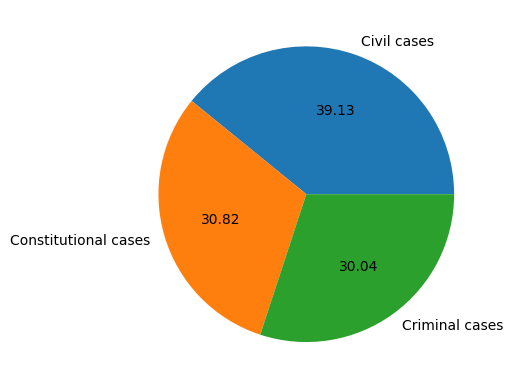

In [12]:
plt.pie(dataset['category'].value_counts(), labels=['Civil cases','Constitutional cases','Criminal cases'],autopct='%0.2f')
plt.show()

In [13]:
dataset.describe()

,statement,category
count,2696,2696
unique,2696,3
top,Challenge to 18th Amendment's Article 175A on ...,Civil
freq,1,1055


In [171]:
dataset['statement'].describe()

count                                                  2696
unique                                                 2696
top       Challenge to 18th Amendment's Article 175A on ...
freq                                                      1
Name: statement, dtype: object

In [172]:
dataset['category'].describe()

count      2696
unique        3
top       Civil
freq       1055
Name: category, dtype: object

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(c) Text Preprocessing:</span>

In [173]:
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()

In [174]:
# not needed on every run . 
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [175]:
corpus = []
for i in range(0, len(dataset)):
    review = re.sub('[^a-zA-Z0-9]', ' ', dataset['statement'].iloc[i])
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [176]:
corpus[90]

'election appeal challenging mna disqualification false qualification widespread electoral irregularity supreme court void election due irregularity'

In [177]:
X = corpus

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">4. Model Building:</span>

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(a) Train Test Split:</span>

In [178]:
# first encode the textual output, i.e category, to labels
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['category'])
# X = corpus 

In [179]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(b) Pipeline Creation:</span>

We used TF-IDF vectorizer here for case category classification because it down-weights common legal terms and highlights the more informative words that help distinguish between categories.

<span style="font-family: 'Times New Roman', serif; font-size: 20px; color: white;">Model used in pipeline : Voting Classifier ( )</span>

We selected the `Voting Classifier` combining three highly performing models i.e `SVC()`, `BernoulliNB()` and `ExtraTreesClassifier()`, as it achieved the best overall performance in terms of precision, F1-score, and accuracy compared to other models.

The other models we trained are also included below in this notebook for reference, along with their output scores.

In [180]:
support_vector_clf = SVC(kernel='sigmoid', gamma=1.0,probability=True)
bernoulliNB = BernoulliNB()
extra_tree_clf = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [181]:
voting_clf = VotingClassifier(estimators=[('svm', support_vector_clf), ('nb', bernoulliNB), ('et', extra_tree_clf)],voting='soft')

In [182]:
# pipeline
voting_pipeline= Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('voting_classifier', voting_clf)
])

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(c) Model Training:</span>

In [183]:
voting_pipeline.fit(X_train,y_train)

,steps,"[('tfidf', ...), ('voting_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">5. Model Evaluation:</span>

Performance in terms of `precision`, `F1-score`, and `accuracy`

In [184]:
y_pred = voting_pipeline.predict(X_test)

In [185]:
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')

Confusion Matrix
 [[197  12   4]
 [ 16 145   2]
 [  0   3 161]] 



In [186]:
print('Classification report\n',classification_report(y_test,y_pred))

Classification report
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       213
           1       0.91      0.89      0.90       163
           2       0.96      0.98      0.97       164

    accuracy                           0.93       540
   macro avg       0.93      0.93      0.93       540
weighted avg       0.93      0.93      0.93       540



In [187]:
print("Train accuracy:", accuracy_score(y_train, voting_pipeline.predict(X_train))*100)
print("Test accuracy :", accuracy_score(y_test, y_pred)*100)
print("Precision Score :", precision_score(y_test, y_pred,average=None)*100)


Train accuracy: 97.86641929499072
Test accuracy : 93.14814814814815
Precision Score : [92.48826291 90.625      96.40718563]


### `Our Remarks on the Model`

Our model demonstrates strong performance with a `train accuracy` of `97.86%` and `test accuracy` of `93.15%`, showing good generalization and minimal overfitting.
Class-wise `precision` and `F1` scores are consistently high, indicating that the model reliably identifies case categories across all classes.
Overall, these results highlight that our model is `robust`, and `accurate`.

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">6. Models We Tried While Building Our Final Model</span>

1. GaussianNB()
2. BernoulliNB()
3. MultinomialNB()

### 1. GaussianNB( )

In [ ]:
# GaussianNB() 
pipe_gnb = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),   # GaussianNB expects dense input, while tfidf gives sparse array so .toarray() converts sparse array to dense array
    ('gaussianNB', GaussianNB())
])

In [109]:
pipe_gnb.fit(X_train,y_train)
y_pred1 = pipe_gnb.predict(X_test)
print('Train Accuracy',accuracy_score(y_train,pipe_gnb.predict(X_train)))
print('Test Accuracy',accuracy_score(y_test,y_pred1))
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred1),'\n')
print('Classification report\n',classification_report(y_test,y_pred1))
print('Precision Score',precision_score(y_test,y_pred1,average=None))

Train Accuracy 0.9782003710575139
Test Accuracy 0.774074074074074
Confusion Matrix
 [[158  42  13]
 [ 30 125   8]
 [  6  23 135]] 

Classification report
               precision    recall  f1-score   support

           0       0.81      0.74      0.78       213
           1       0.66      0.77      0.71       163
           2       0.87      0.82      0.84       164

    accuracy                           0.77       540
   macro avg       0.78      0.78      0.78       540
weighted avg       0.78      0.77      0.78       540

Precision Score [0.81443299 0.65789474 0.86538462]


### `Remarks:`

GaussianNB( ) is performing very poorly on this dataset.


### 2. MultinomialNB( )

In [ ]:
# MultinomialNB() 
pipe_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('multinomialNB', MultinomialNB())
])

In [110]:
pipe_mnb.fit(X_train,y_train)
y_pred = pipe_mnb.predict(X_test)
print('Train Accuracy',accuracy_score(y_train,pipe_mnb.predict(X_train)))
print('Test Accuracy',accuracy_score(y_test,y_pred))
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')
print('Classification report\n',classification_report(y_test,y_pred))
print('Precision Score',precision_score(y_test,y_pred,average=None))

Train Accuracy 0.9452690166975881
Test Accuracy 0.9111111111111111
Confusion Matrix
 [[194  13   6]
 [ 19 142   2]
 [  0   8 156]] 

Classification report
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       213
           1       0.87      0.87      0.87       163
           2       0.95      0.95      0.95       164

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540

Precision Score [0.91079812 0.87116564 0.95121951]


### `Remarks:`

MultinomialNB( ) is performing pretty good except that precision of category 1 is comparativley lower than that of voting classifier.

### 3. BernoulliNB( )

In [ ]:
pipe_bnb = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('bernoulliNB', BernoulliNB())
])

In [111]:
pipe_bnb.fit(X_train,y_train)
y_pred = pipe_bnb.predict(X_test)
print('Train Accuracy',accuracy_score(y_train,pipe_bnb.predict(X_train)))
print('Test Accuracy',accuracy_score(y_test,y_pred))
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')
print('Classification report\n',classification_report(y_test,y_pred))
print('Precision Score',precision_score(y_test,y_pred,average=None))

Train Accuracy 0.9522263450834879
Test Accuracy 0.924074074074074
Confusion Matrix
 [[196  13   4]
 [ 17 144   2]
 [  0   5 159]] 

Classification report
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       213
           1       0.89      0.88      0.89       163
           2       0.96      0.97      0.97       164

    accuracy                           0.92       540
   macro avg       0.92      0.92      0.92       540
weighted avg       0.92      0.92      0.92       540

Precision Score [0.92018779 0.88888889 0.96363636]


### `Remarks:`

BernoulliNB( ) performs very well on its own, but it still lags behind the Voting Classifier, which achieves high precision across all three categories.

### <span style="font-family: 'Times New Roman', serif; font-size: 25px; color: white;">Hyperparameter Tuning Code</span>

In [113]:
tuning_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('bnb', BernoulliNB())
])

# Parameter grid 
param_grid = {
    # TfidfVectorizer
    'tfidf__ngram_range': [(1,1), (1,2)],        
    'tfidf__min_df': [1, 2],               
    'tfidf__max_df': [0.75, 0.9, 1.0],         
    'tfidf__use_idf': [True, False],                
    'tfidf__smooth_idf': [True, False], 
    'tfidf__sublinear_tf': [True, False],   

    # BernoulliNB hyperparams
    'bnb__alpha': [0.1, 0.5, 1.0],                       
    'bnb__fit_prior': [True, False],                    
    'bnb__binarize': [None, 0.0, 0.5]       
}

# Cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV object
grid = GridSearchCV(
    estimator=tuning_pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',   
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run grid search
grid.fit(X_train, y_train)

# Best params / score
print("Best cross-val F1 (weighted):", grid.best_score_)
print("Best params:", grid.best_params_)

# Evaluate best model on test set
best = grid.best_estimator_
y_pred = best.predict(X_test)

print("\nTrain accuracy:", accuracy_score(y_train, best.predict(X_train)))
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best cross-val F1 (weighted): 0.9037011684785023
Best params: {'bnb__alpha': 0.1, 'bnb__binarize': None, 'bnb__fit_prior': False, 'tfidf__max_df': 0.75, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False}

Train accuracy: 0.9921150278293135
Test accuracy : 0.9185185185185185

Confusion Matrix:
 [[194  13   6]
 [ 18 143   2]
 [  0   5 159]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9151    0.9108    0.9129       213
           1     0.8882    0.8773    0.8827       163
           2     0.9521    0.9695    0.9607       164

    accuracy                         0.9185       540
   macro avg     0.9185    0.9192    0.9188       540
weighted avg     0.9182    0.9185    0.9183       540



### `Remarks:`

Hyperparameter tuned BernoulliNB() performs well on its own, but it still lags behind the Voting Classifier, which achieves high precision across all three categories.

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">4. Training 10 Models and evaluating their output</span>


In [116]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [117]:
clfs = {
    'Support Vector Classifier' : svc,
    'KNearest Neighbor' : knc, 
    'Decision Tree Classifier': dtc, 
    'Logistic Regression': lrc, 
    'Random Forest Classifier': rfc, 
    'AdaBoost': abc, 
    'Bagging ClassifierC': bc, 
    'Extra Trees Classifier': etc,
    'Gradient BoostingcClassifier':gbdt,
    'XGBoost Classifier':xgb
}

In [123]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf_pipeline=Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('classifier', clf)
    ])
    clf_pipeline.fit(X_train,y_train)
    y_pred = clf_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='micro')
    cr = classification_report(y_test,y_pred)
    
    return accuracy,precision,cr

In [124]:
for name,clf in clfs.items():
    
    current_accuracy,current_precision,current_cr = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("Classification Report",current_cr)
    print('---------------'*9)

For  Support Vector Classifier
Accuracy -  0.9148148148148149
Precision -  0.9148148148148149
Classification Report               precision    recall  f1-score   support

           0       0.92      0.91      0.91       213
           1       0.87      0.88      0.87       163
           2       0.96      0.96      0.96       164

    accuracy                           0.91       540
   macro avg       0.91      0.92      0.91       540
weighted avg       0.91      0.91      0.91       540

---------------------------------------------------------------------------------------------------------------------------------------
For  KNearest Neighbor
Accuracy -  0.8870370370370371
Precision -  0.8870370370370371
Classification Report               precision    recall  f1-score   support

           0       0.84      0.92      0.88       213
           1       0.90      0.80      0.85       163
           2       0.94      0.93      0.94       164

    accuracy                           0.

d:\judiciary and law project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


For  Logistic Regression
Accuracy -  0.9092592592592592
Precision -  0.9092592592592592
Classification Report               precision    recall  f1-score   support

           0       0.88      0.93      0.91       213
           1       0.90      0.80      0.85       163
           2       0.95      0.98      0.96       164

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540

---------------------------------------------------------------------------------------------------------------------------------------
For  Random Forest Classifier
Accuracy -  0.9111111111111111
Precision -  0.9111111111111111
Classification Report               precision    recall  f1-score   support

           0       0.90      0.92      0.91       213
           1       0.91      0.83      0.87       163
           2       0.93      0.98      0.95       164

    accuracy                           0

### `Remarks:` 

SVC( ) and ExtraTreesClassifier( ) are the best performing models among all 10, but they lag behind the voting classifier

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">5. Training One more Model</span>

* Stacking Classifier

### <span style="font-family: 'Times New Roman', serif; font-size: 25px; color: white;"> Stacking Classifier</span>

In [130]:
estimators=[('svm', svc), ('nb', MultinomialNB()), ('et', etc)]
final_estimator=RandomForestClassifier()

In [133]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [134]:
stacking_pipeline= Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('stacking_classifier', stacking_clf)
])


In [135]:
stacking_pipeline.fit(X_train,y_train)

,steps,"[('tfidf', ...), ('stacking_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [137]:
y_pred = stacking_pipeline.predict(X_test)
print('Train Accuracy',accuracy_score(y_train,stacking_pipeline.predict(X_train)))
print('Test Accuracy',accuracy_score(y_test,y_pred))
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')
print('Classification report\n',classification_report(y_test,y_pred))
print('Precision Score',precision_score(y_test,y_pred,average=None))

Train Accuracy 0.9823747680890538
Test Accuracy 0.9092592592592592
Confusion Matrix
 [[189  17   7]
 [ 17 140   6]
 [  0   2 162]] 

Classification report
               precision    recall  f1-score   support

           0       0.92      0.89      0.90       213
           1       0.88      0.86      0.87       163
           2       0.93      0.99      0.96       164

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540

Precision Score [0.91747573 0.88050314 0.92571429]


### `Remarks:`

Stacking classifier is performing well but lags behind voting classifier in precision across category 1

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">7. Web Application Development</span>

In [190]:
pickle.dump(voting_pipeline,open('voting_pipeline.pkl','wb'))
pickle.dump(encoder,open('label_encoder.pkl','wb'))